In [63]:
# %%

In [64]:
# %%# Step 1: Setup and imports
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mlrose_hiive import ExpDecay, NeuralNetwork
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [65]:
# %%

In [66]:
# %%
# Step 2: Load and preprocess data
data = load_iris()
X = data.data
y = data.target

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# One-hot encode the target
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



In [67]:
# %%

In [68]:
# %%
# Step 3: Define a function to train and evaluate the neural network


class NeuralNetworkWrapper(NeuralNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.classes_ = [0, 1, 2]


def train_evaluate_nn(algorithm, **kwargs):
    nn = NeuralNetworkWrapper(
        hidden_nodes=[10],
        activation="sigmoid",
        algorithm=algorithm,
        max_iters=100,
        bias=True,
        is_classifier=True,
        learning_rate=0.01,
        early_stopping=True,
        clip_max=5,
        random_state=42,
        curve=True,
        **kwargs,
    )

    start_time = time.time()
    nn.fit(X_train, y_train)
    train_time = time.time() - start_time

    start_time = time.time()
    y_pred = nn.predict(X_test)
    predict_time = time.time() - start_time

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    return accuracy, f1, train_time, predict_time, nn



In [69]:
# %%

In [70]:
# %%
# Step 4: Define a function to tune hyperparameters


def tune_hyperparameters(algorithm, param_name, param_values, **kwargs):
    results = []

    for value in param_values:
        params = {param_name: value}
        params.update(kwargs)
        accuracy, f1, train_time, predict_time, _ = train_evaluate_nn(
            algorithm, **params
        )
        results.append((value, accuracy, f1, train_time, predict_time))

    return results



In [71]:
# %%

In [72]:
# %%
# Step 5: Perform hyperparameter tuning and plot the results


def plot_tuning_results(results, param_name):
    param_values = [
        r[0].exp_const if isinstance(r[0], ExpDecay) else r[0] for r in results
    ]
    accuracies = [r[1] for r in results]
    f1_scores = [r[2] for r in results]
    train_times = [r[3] for r in results]
    predict_times = [r[4] for r in results]

    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    sns.set_style("whitegrid")
    colors = sns.color_palette("husl", 4)

    axes[0, 0].plot(param_values, accuracies, marker="o", color=colors[0])
    axes[0, 0].set_title(f"Accuracy vs {param_name}")
    axes[0, 0].set_xlabel(param_name)
    axes[0, 0].set_ylabel("Accuracy")

    axes[0, 1].plot(param_values, f1_scores, marker="o", color=colors[1])
    axes[0, 1].set_title(f"F1 Score vs {param_name}")
    axes[0, 1].set_xlabel(param_name)
    axes[0, 1].set_ylabel("F1 Score")

    axes[1, 0].plot(param_values, train_times, marker="o", color=colors[2])
    axes[1, 0].set_title(f"Training Time vs {param_name}")
    axes[1, 0].set_xlabel(param_name)
    axes[1, 0].set_ylabel("Time (seconds)")

    axes[1, 1].plot(param_values, predict_times, marker="o", color=colors[3])
    axes[1, 1].set_title(f"Prediction Time vs {param_name}")
    axes[1, 1].set_xlabel(param_name)
    axes[1, 1].set_ylabel("Time (seconds)")

    plt.tight_layout()
    plt.show()



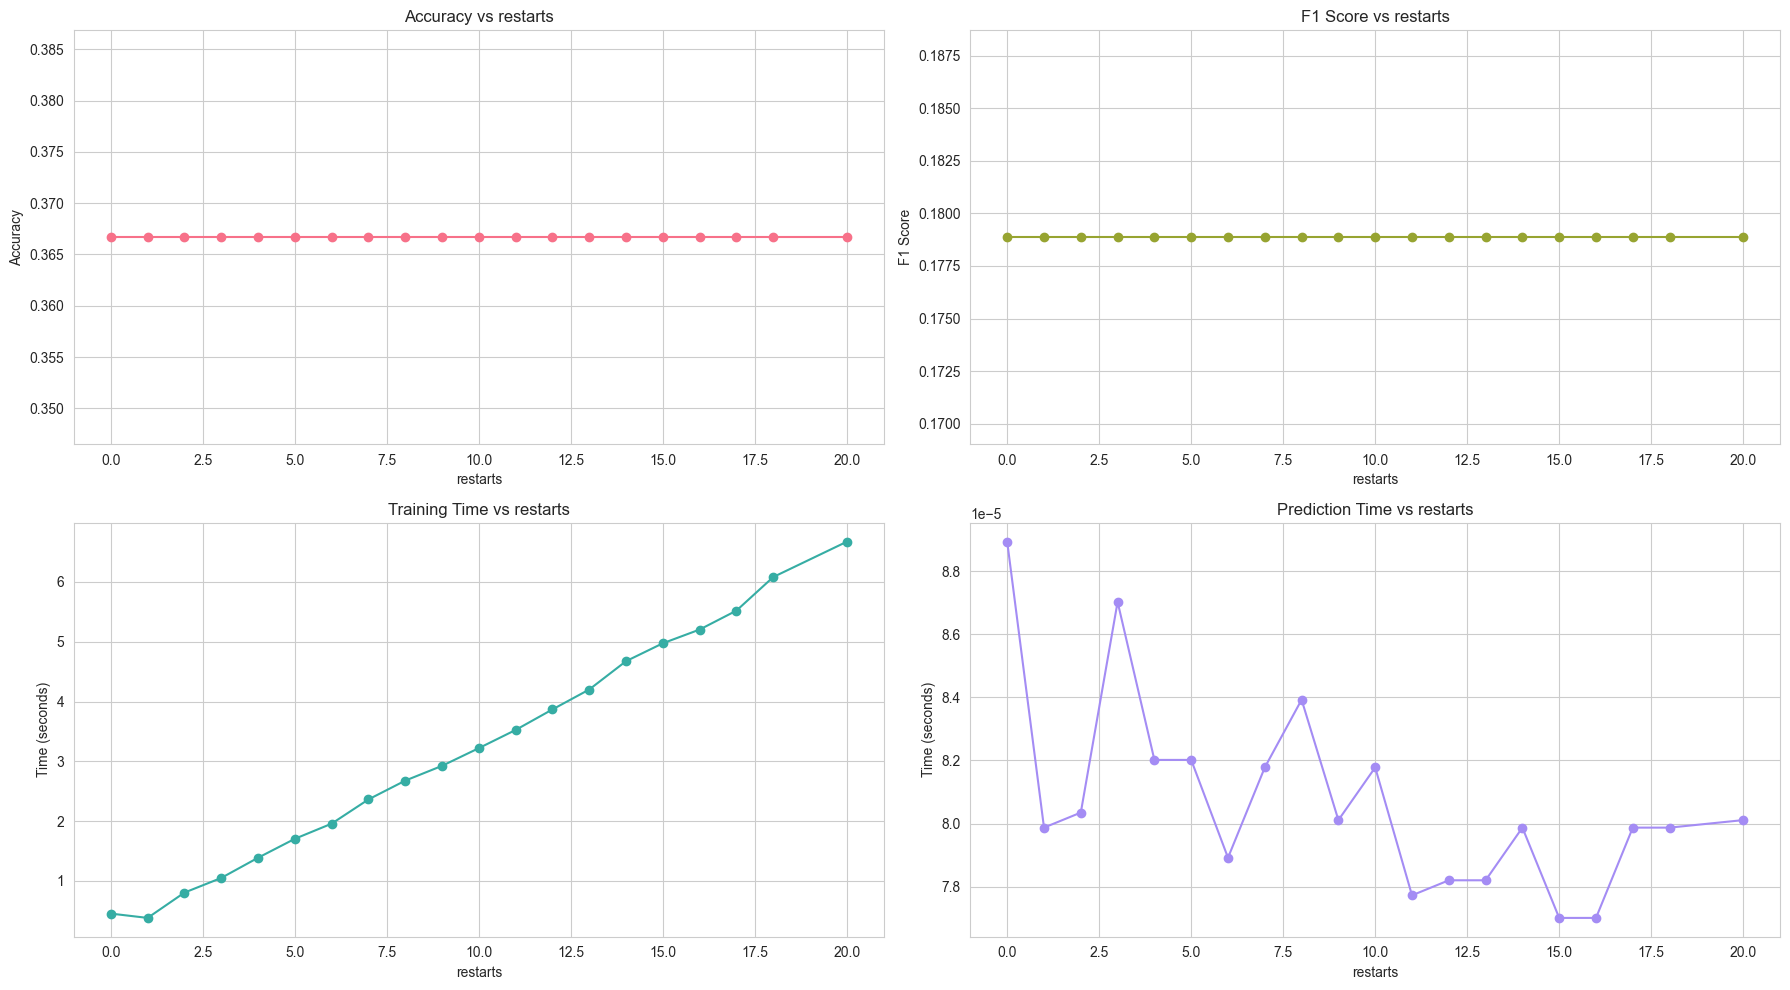

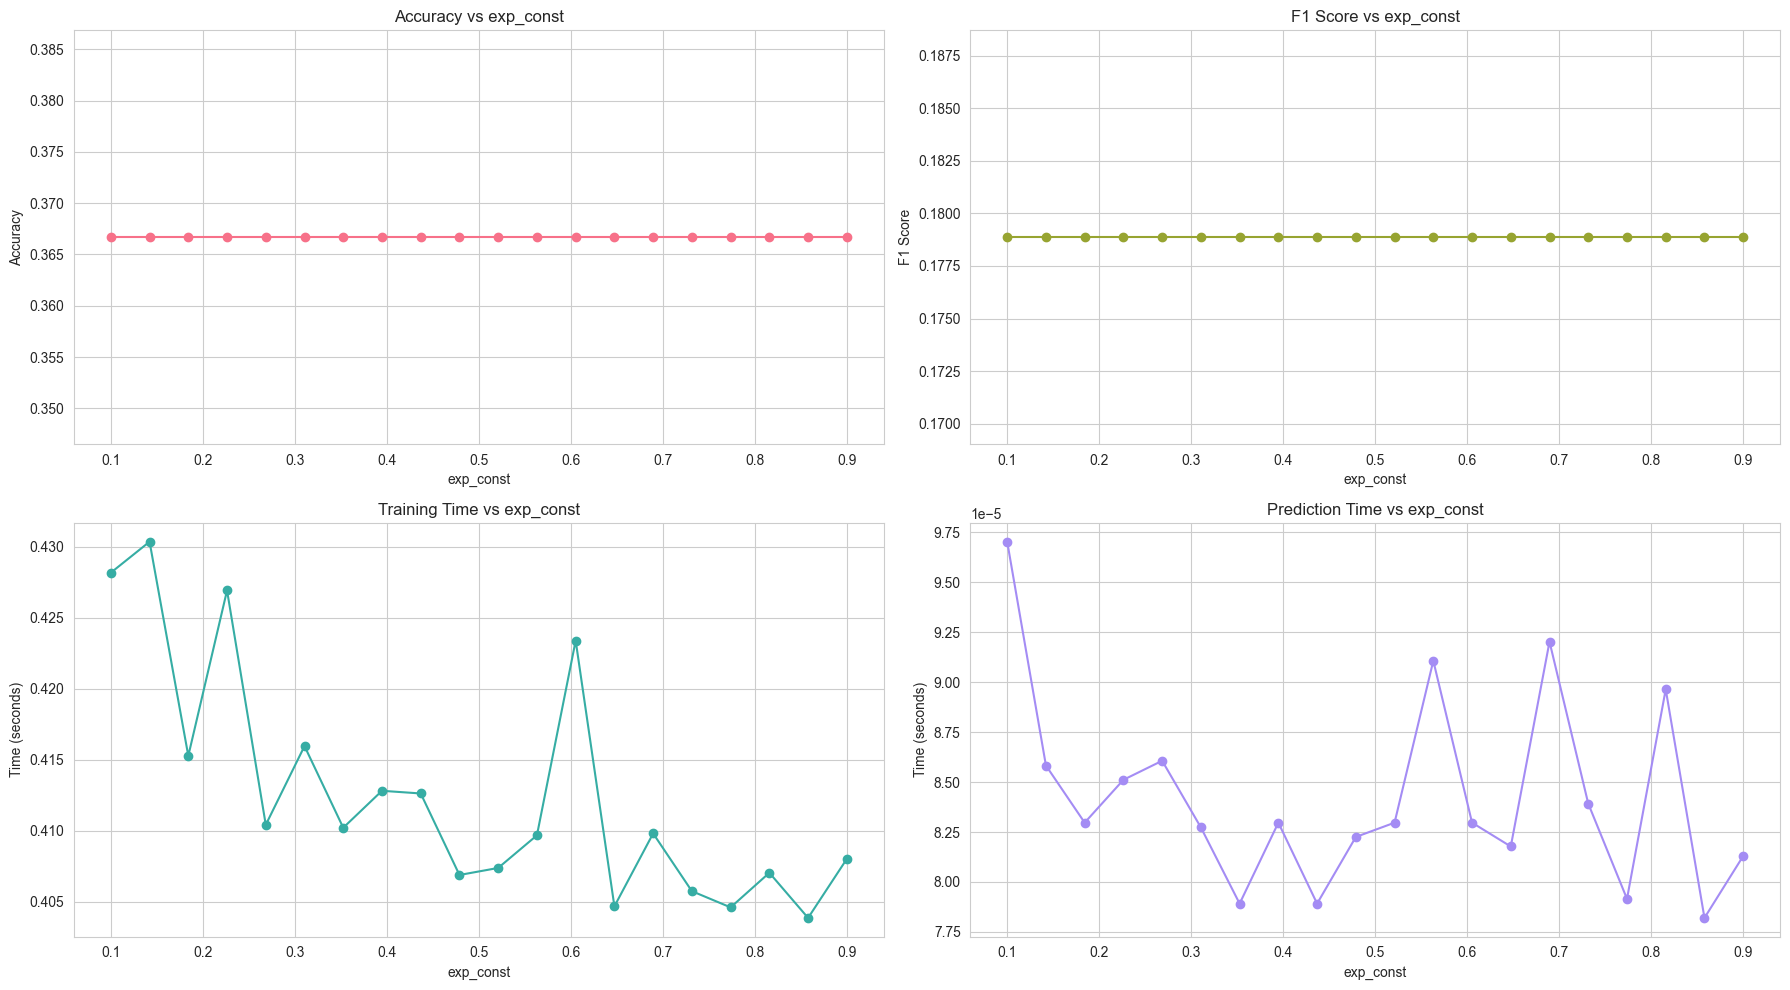

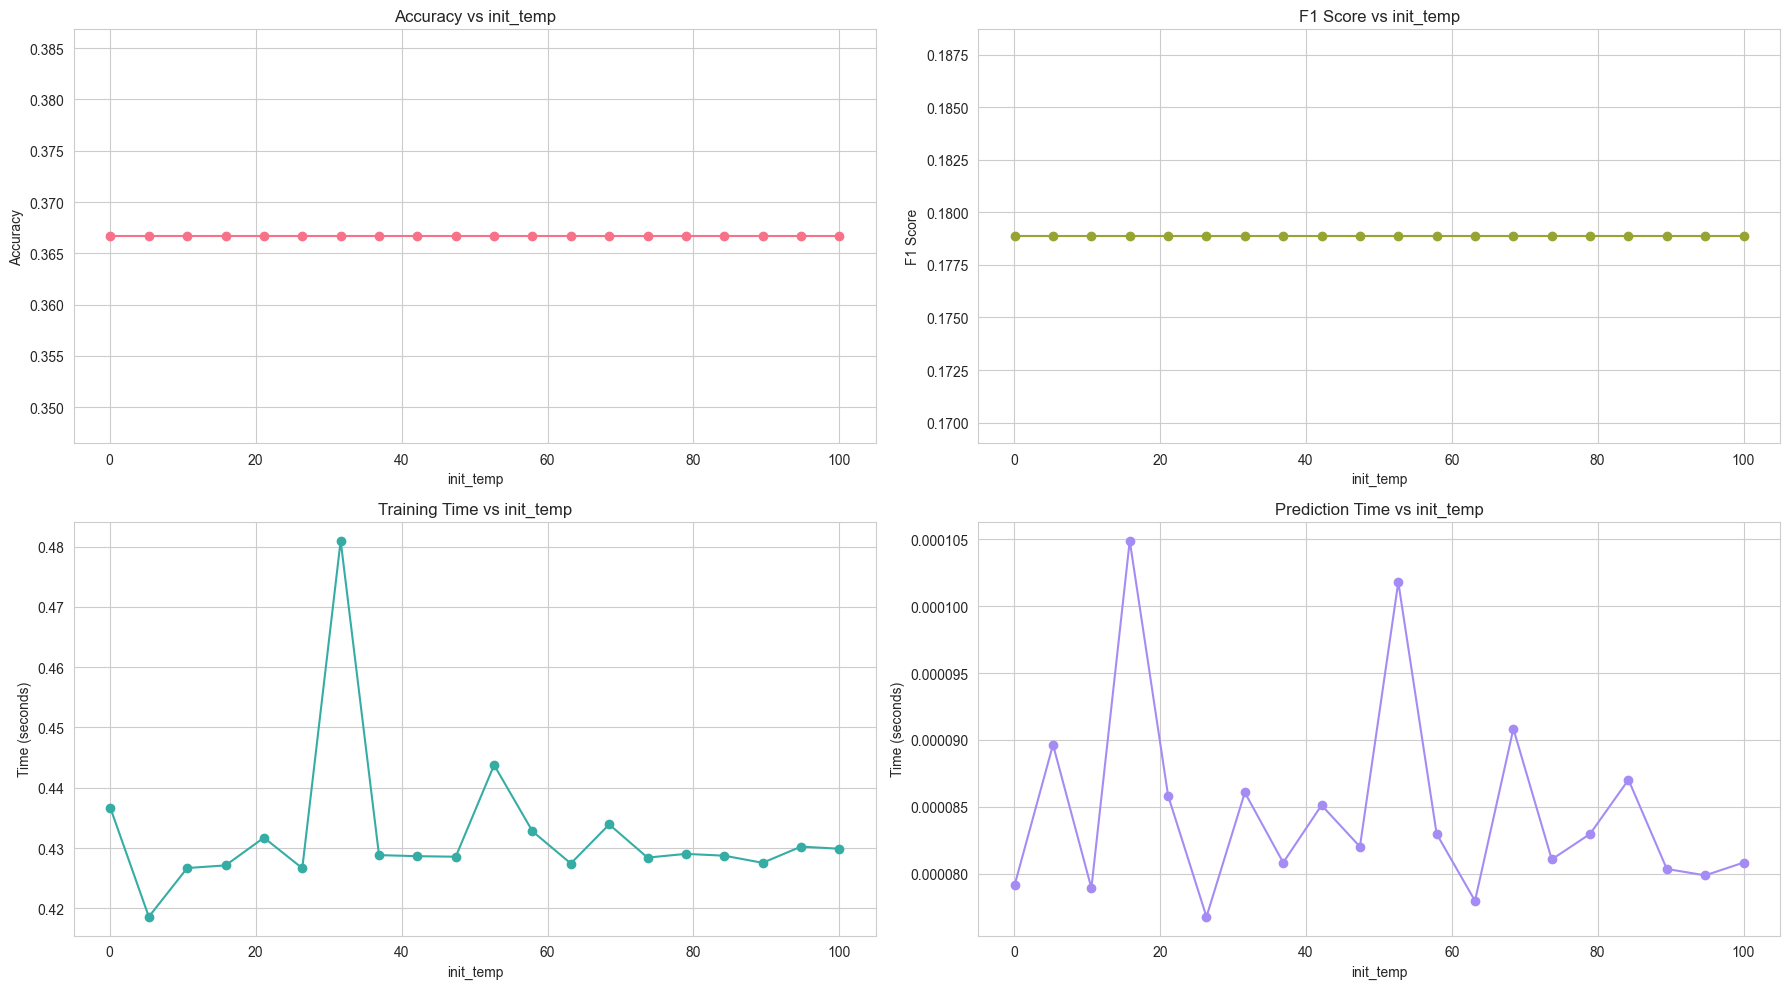

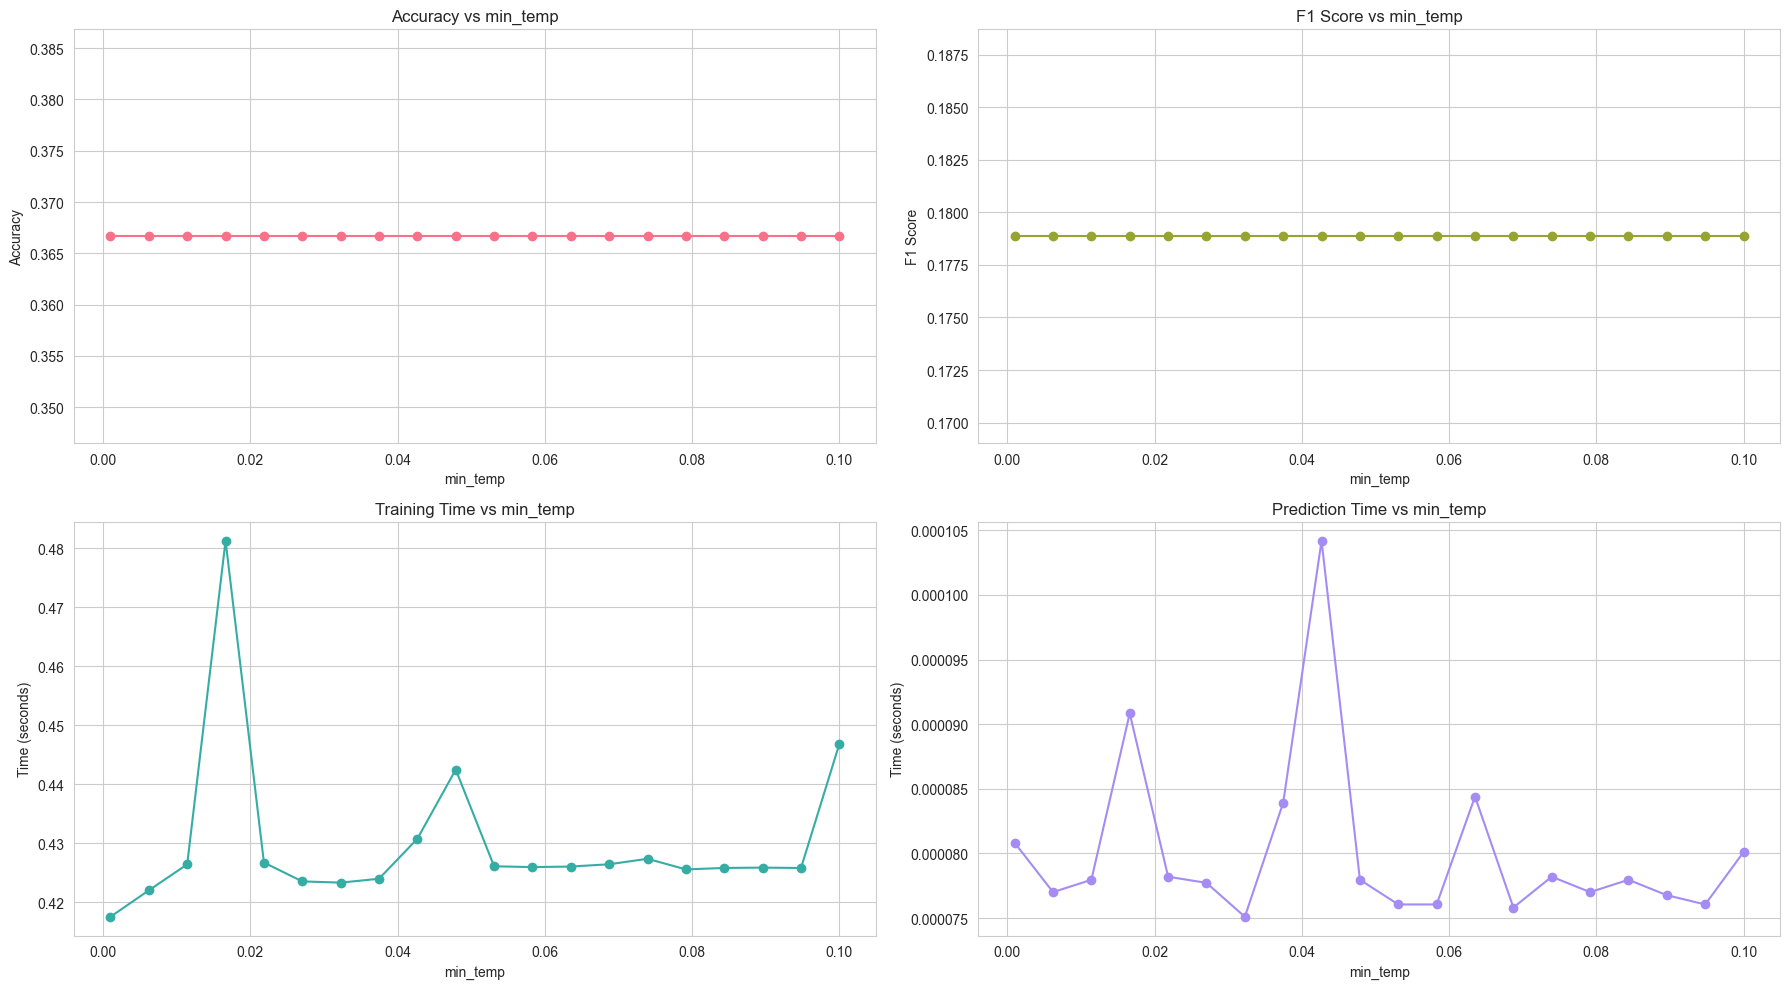

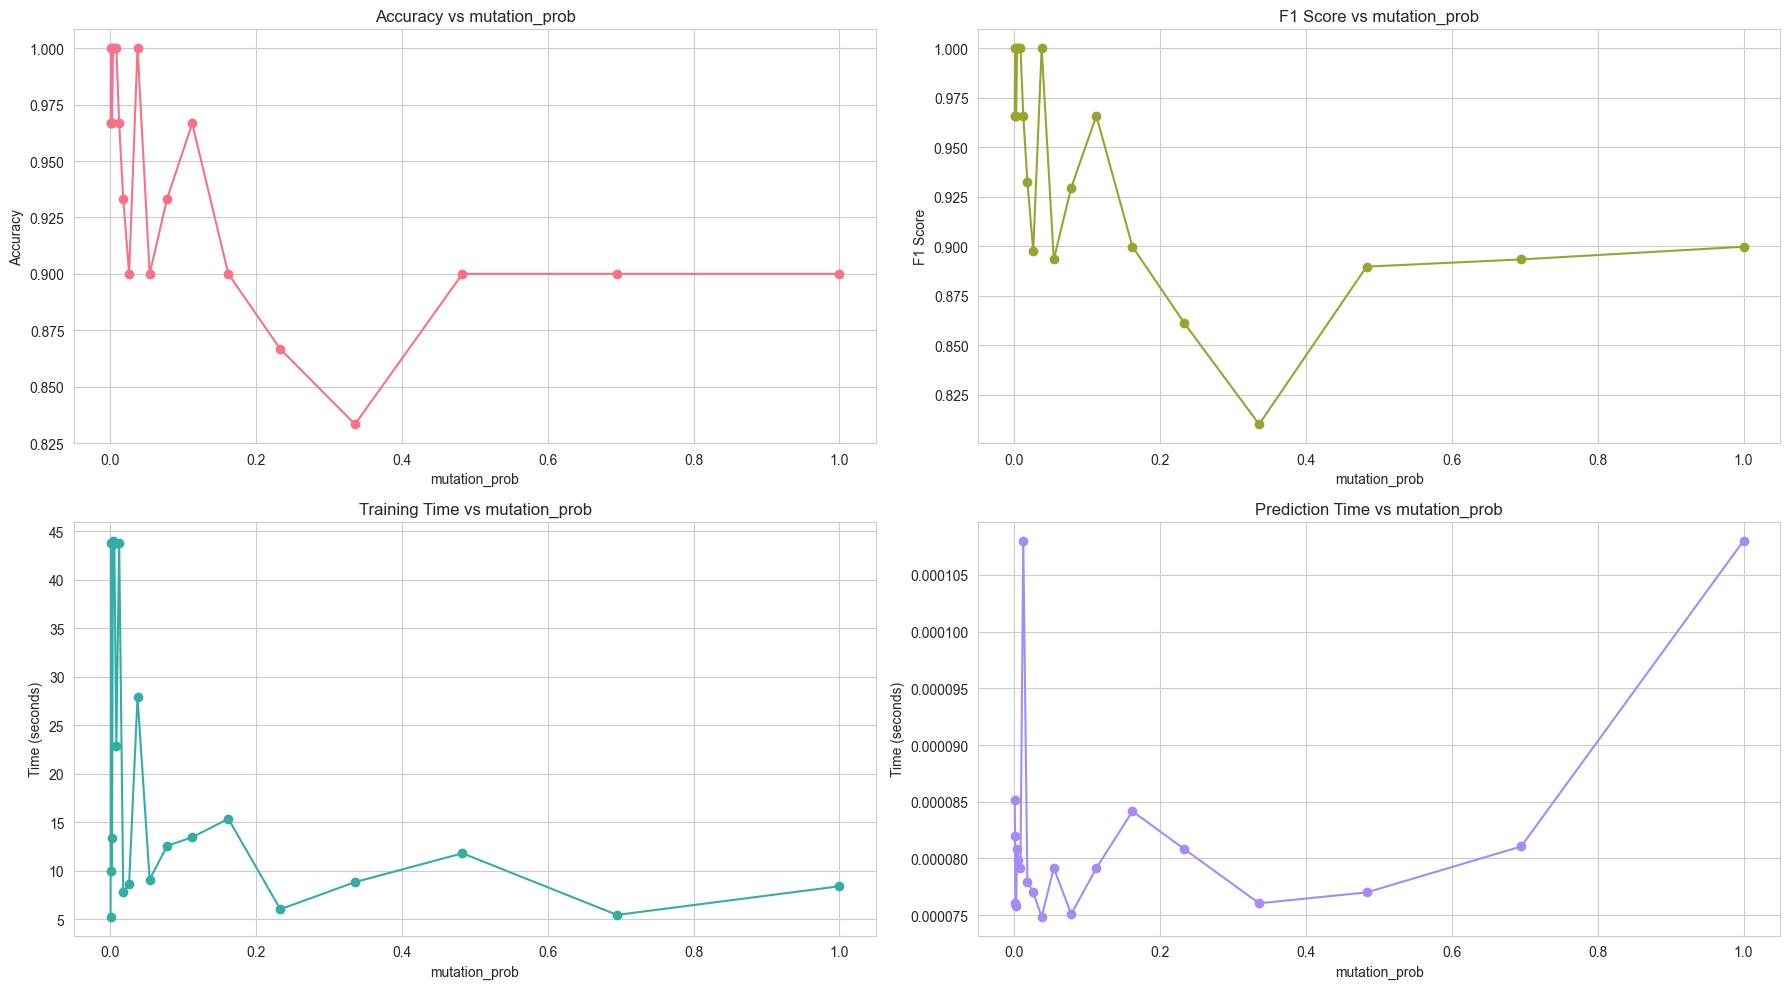

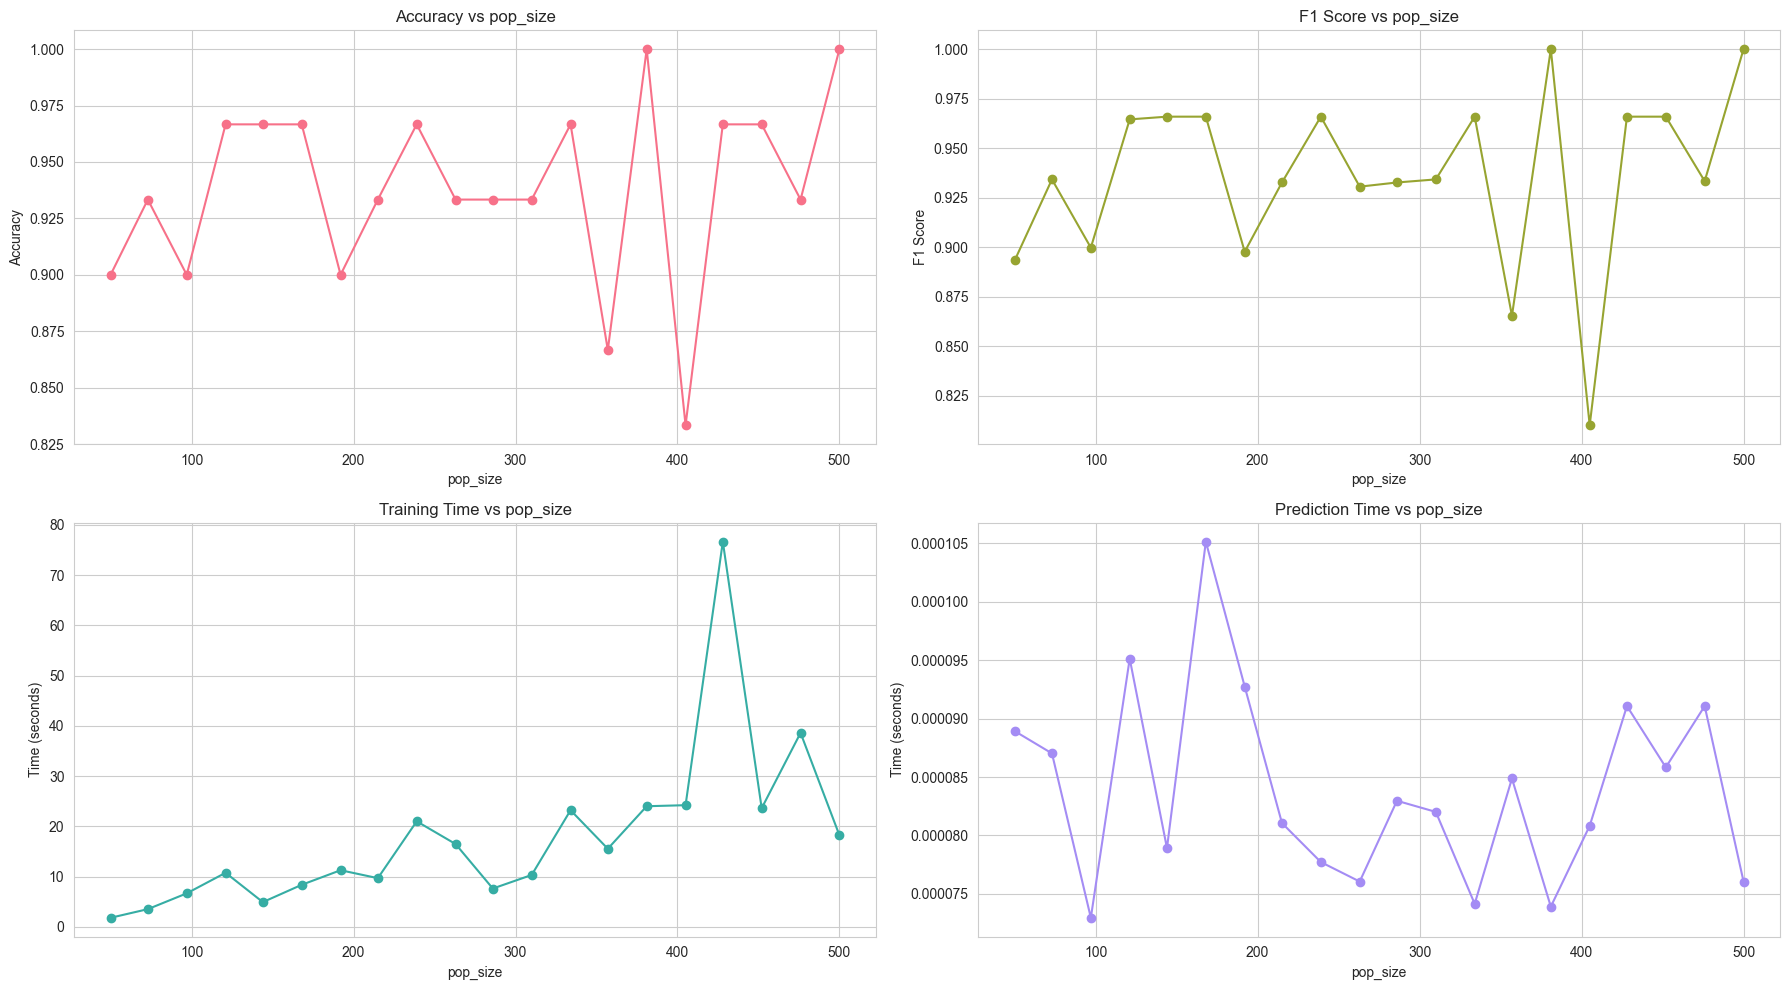

In [73]:
# %%
# Step 6: Tune and plot for each algorithm and hyperparameter

# Randomized Hill Climbing: restarts
rhc_param_name = "restarts"
rhc_param_values = np.linspace(0, 20, 20, dtype=int)
rhc_tuning_results = tune_hyperparameters(
    "random_hill_climb", rhc_param_name, rhc_param_values
)
plot_tuning_results(rhc_tuning_results, rhc_param_name)

# Simulated Annealing: schedule (decay rate) with exponential decay
sa_param_name = "schedule"
sa_param_values = [
    ExpDecay(init_temp=1.0, exp_const=i, min_temp=0.001) for i in np.linspace(0.1, 0.9, 20)
]
sa_tuning_results = tune_hyperparameters(
    "simulated_annealing", sa_param_name, sa_param_values
)
sa_tuning_results = [(r[0].exp_const, r[1], r[2], r[3], r[4]) for r in sa_tuning_results]
plot_tuning_results(sa_tuning_results, 'exp_const')

# Simulated Annealing: schedule (decay rate) with geometric decay
sa_param_name = "schedule"
sa_param_values = [
    ExpDecay(init_temp = i, exp_const=0.1, min_temp=0.001) for i in np.linspace(0.1, 100, 20)
]
sa_tuning_results = tune_hyperparameters(
    "simulated_annealing", sa_param_name, sa_param_values
)
sa_tuning_results = [(r[0].init_temp, r[1], r[2], r[3], r[4]) for r in sa_tuning_results]
plot_tuning_results(sa_tuning_results, 'init_temp')

# Simulated Annealing: schedule (decay rate) with arithmetic decay
sa_param_name = "schedule"
sa_param_values = [
    ExpDecay(init_temp=1.0, exp_const=0.1, min_temp=i) for i in np.linspace(0.001, 0.1, 20)
]
sa_tuning_results = tune_hyperparameters(
    "simulated_annealing", sa_param_name, sa_param_values
)
sa_tuning_results = [(r[0].min_temp, r[1], r[2], r[3], r[4]) for r in sa_tuning_results]
plot_tuning_results(sa_tuning_results, 'min_temp')


# Genetic Algorithm: mutation_prob
ga_param_name = "mutation_prob"
ga_param_values = np.logspace(-3, 0, 20)
ga_tuning_results = tune_hyperparameters(
    "genetic_alg", ga_param_name, ga_param_values, pop_size=200
)
plot_tuning_results(ga_tuning_results, ga_param_name)

# Genetic Algorithm: pop_size
ga_param_name = "pop_size"
ga_param_values = np.linspace(50, 500, 20, dtype=int)
ga_tuning_results = tune_hyperparameters(
    "genetic_alg", ga_param_name, ga_param_values, mutation_prob=0.1
)
plot_tuning_results(ga_tuning_results, ga_param_name)


In [74]:
# %%

In [75]:
# %%
# Step 7: Train and evaluate using the best hyperparameters
results = {}

# Randomized Hill Climbing
rhc_results = train_evaluate_nn("random_hill_climb", restarts=1)
results["RHC"] = rhc_results

# Simulated Annealing
sa_results = train_evaluate_nn("simulated_annealing", schedule=ExpDecay(exp_const=0.2, init_temp=0.1, min_temp=0.001))
results["SA"] = sa_results

# Genetic Algorithm
ga_results = train_evaluate_nn("genetic_alg", pop_size=380, mutation_prob=10**-3)
results["GA"] = ga_results

# Standard Backpropagation
backprop_results = train_evaluate_nn("gradient_descent")
results["Backprop"] = backprop_results



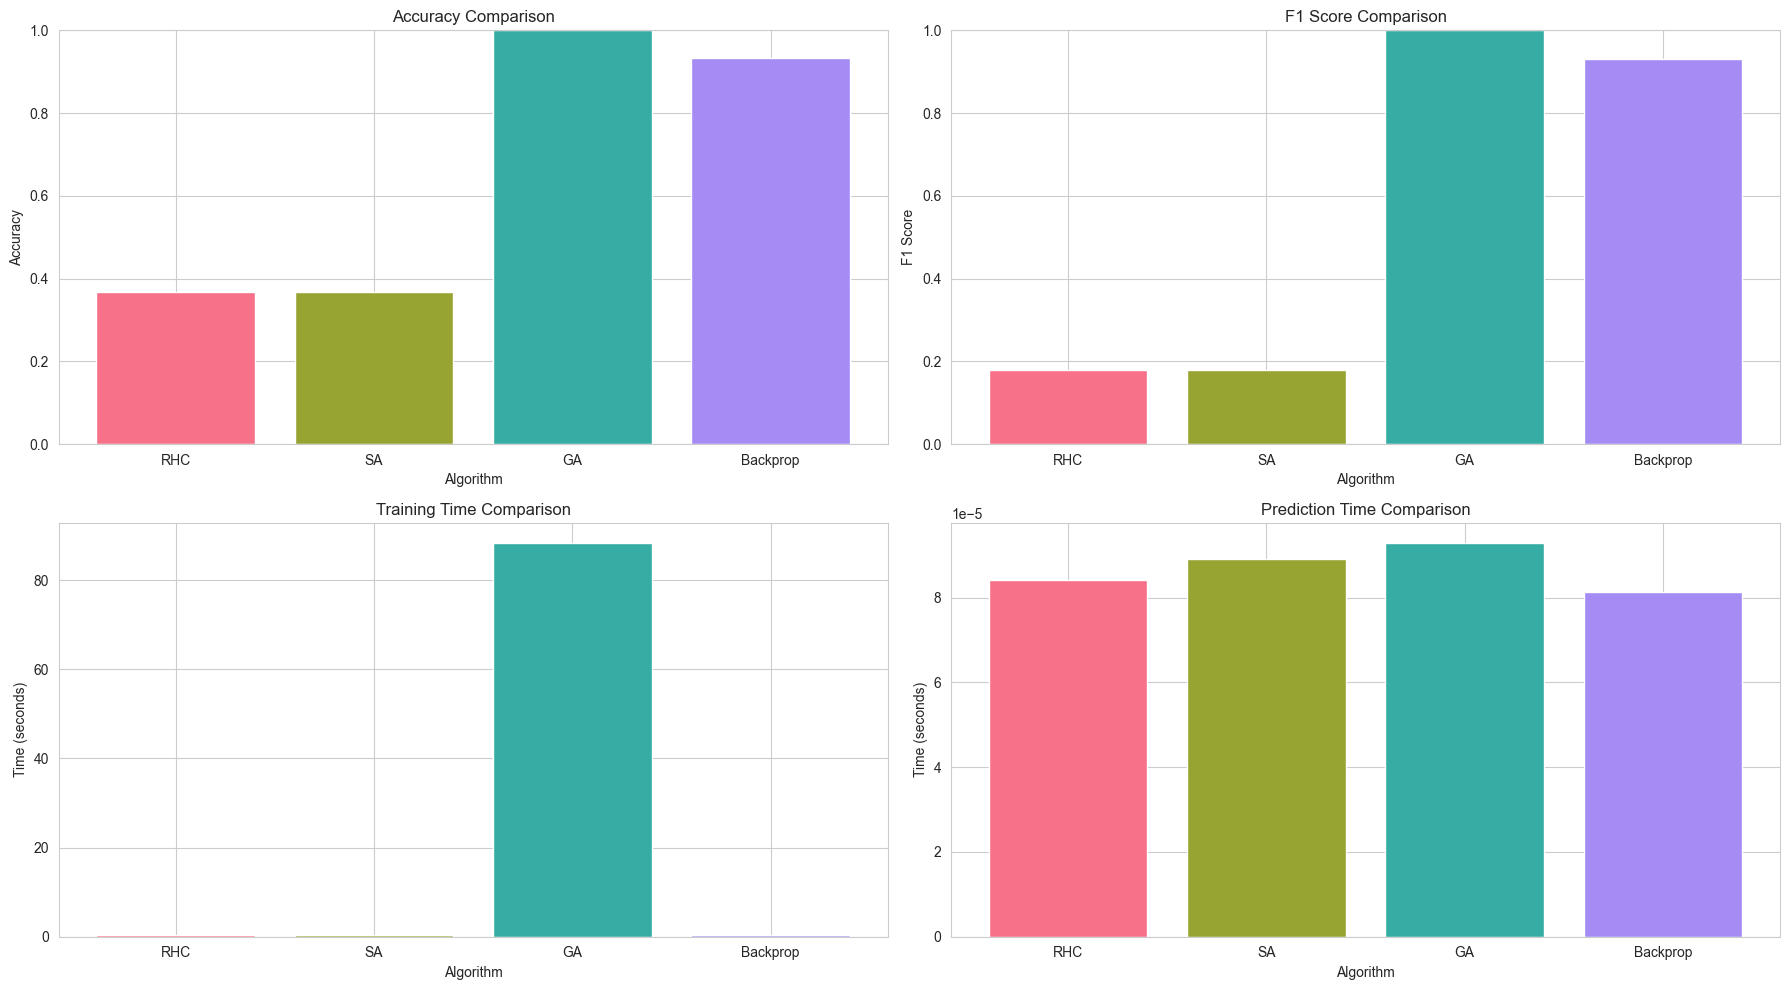

In [76]:
# %%
# Step 8: Visualization of Results
algorithms = list(results.keys())
accuracies = [results[algo][0] for algo in algorithms]
f1_scores = [results[algo][1] for algo in algorithms]
train_times = [results[algo][2] for algo in algorithms]
predict_times = [results[algo][3] for algo in algorithms]

plt.figure(figsize=(18, 10))
sns.set_style("whitegrid")
colors = sns.color_palette("husl", len(algorithms))

# Plot accuracy
plt.subplot(2, 2, 1)
plt.bar(algorithms, accuracies, color=colors)
plt.title("Accuracy Comparison")
plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

# Plot F1 Score
plt.subplot(2, 2, 2)
plt.bar(algorithms, f1_scores, color=colors)
plt.title("F1 Score Comparison")
plt.xlabel("Algorithm")
plt.ylabel("F1 Score")
plt.ylim(0, 1)

# Plot training and prediction times
plt.subplot(2, 2, 3)
plt.bar(algorithms, train_times, color=colors, label="Train Time")
plt.title("Training Time Comparison")
plt.xlabel("Algorithm")
plt.ylabel("Time (seconds)")

plt.subplot(2, 2, 4)
plt.bar(algorithms, predict_times, color=colors, label="Predict Time")
plt.title("Prediction Time Comparison")
plt.xlabel("Algorithm")
plt.ylabel("Time (seconds)")

plt.tight_layout()
plt.savefig("nn_results.png")
plt.show()



In [77]:
# %%

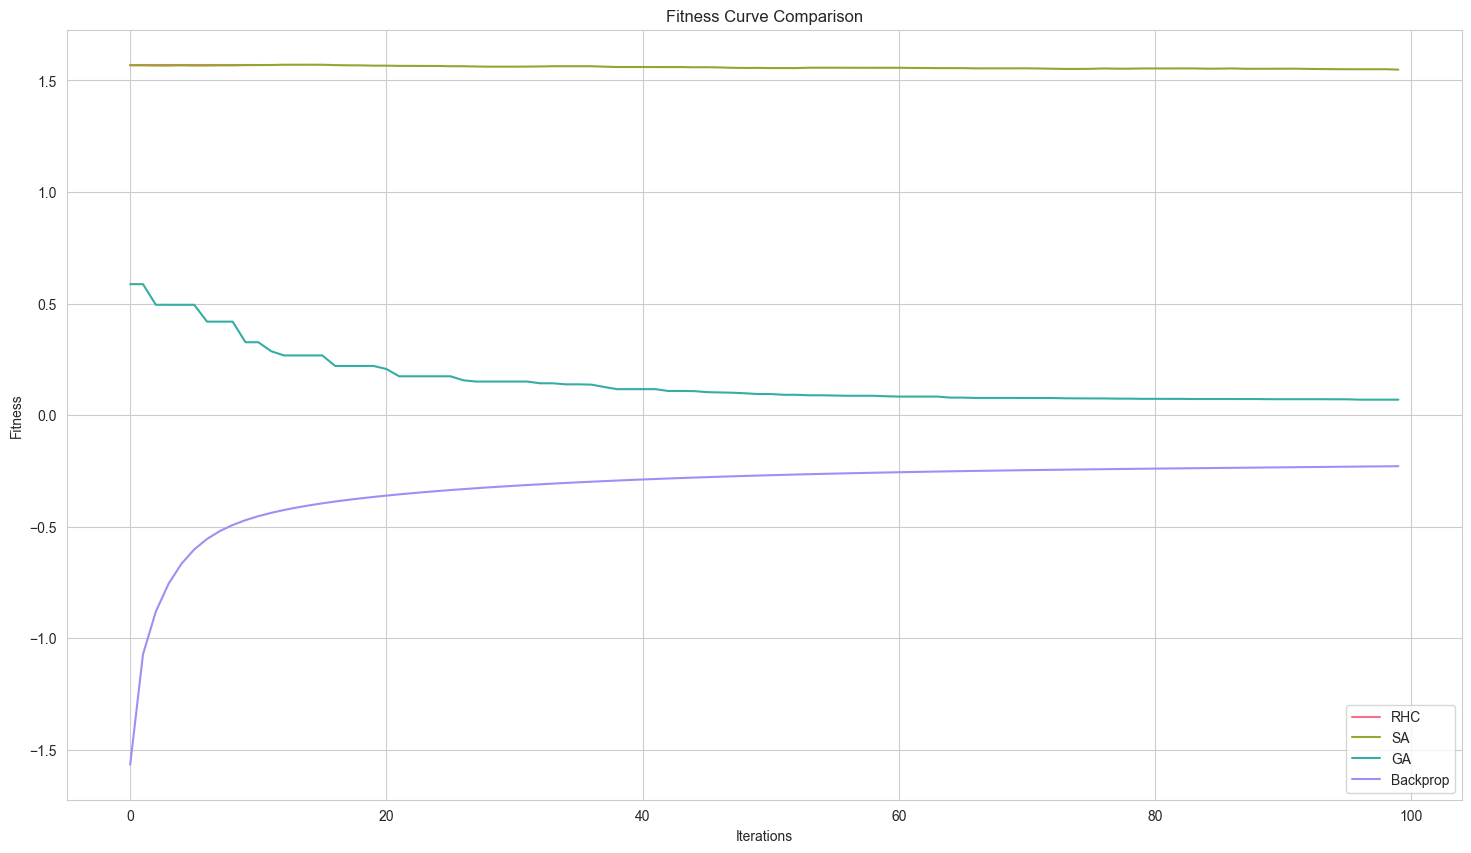

In [78]:
# %%
# Step 9: Plot fitting curves
sns.set_style("whitegrid")
colors = sns.color_palette("husl", len(algorithms))
plt.figure(figsize=(18, 10))
for algo in algorithms:
    nn = results[algo][4]
    # convert two-dimensional array to np array
    fitness_curve = np.array(nn.fitness_curve)
    y_axis = fitness_curve[:, 0] if algo != "Backprop" else fitness_curve
    plt.plot(y_axis, label=algo, color=colors[algorithms.index(algo)])

plt.title("Fitness Curve Comparison")
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.legend()
plt.savefig("nn_fitness_curve.png")
plt.show()



In [79]:
# %%

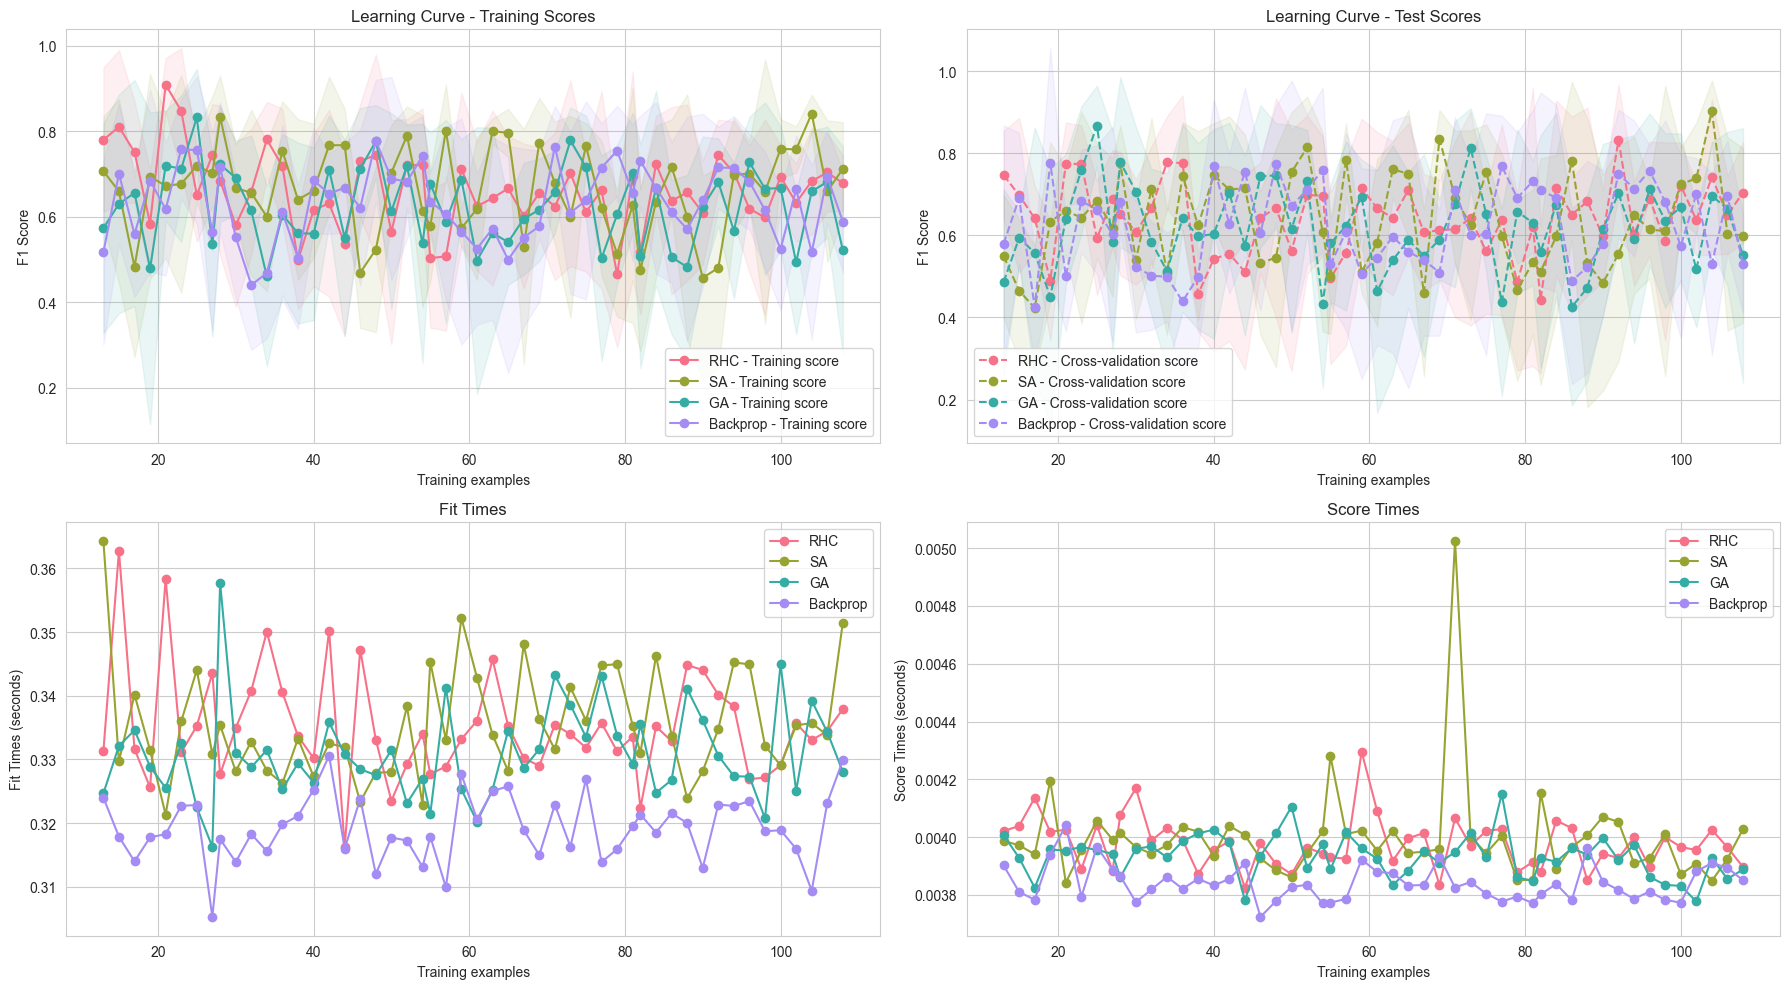

In [80]:
# %%
# Step 10: Learning Curve

from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, learning_curve


def plot_all_curves(algorithms, results):
    sns.set_style("whitegrid")
    colors = sns.color_palette("husl", len(algorithms))

    fig, axes = plt.subplots(2, 2, figsize=(18, 10))

    for idx, algo in enumerate(algorithms):
        nn = results[algo][4]
        cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=42)

        def f1_macro(y_true, y_pred):
            return f1_score(y_true, y_pred, average="macro")

        scorer = make_scorer(f1_macro)
        train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
            nn,
            X,
            y,
            cv=cv,
            scoring=scorer,
            train_sizes=np.linspace(0.1, 0.8, 50),
            random_state=42,
            return_times=True,
            shuffle=True,
        )

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)

        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot training scores
        axes[0, 0].fill_between(
            train_sizes,
            train_scores_mean - train_scores_std,
            train_scores_mean + train_scores_std,
            alpha=0.1,
            color=colors[idx],
        )
        axes[0, 0].plot(
            train_sizes,
            train_scores_mean,
            "o-",
            color=colors[idx],
            label=f"{algo} - Training score",
        )

        # Plot test scores
        axes[0, 1].fill_between(
            train_sizes,
            test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std,
            alpha=0.1,
            color=colors[idx],
        )
        axes[0, 1].plot(
            train_sizes,
            test_scores_mean,
            "o-",
            color=colors[idx],
            linestyle="--",
            label=f"{algo} - Cross-validation score",
        )

        # Plot fit times
        axes[1, 0].plot(
            train_sizes, fit_times.mean(axis=1), "o-", color=colors[idx], label=algo
        )

        # Plot score times
        axes[1, 1].plot(
            train_sizes, score_times.mean(axis=1), "o-", color=colors[idx], label=algo
        )

    # Set titles and labels
    axes[0, 0].set_title("Learning Curve - Training Scores")
    axes[0, 0].set_xlabel("Training examples")
    axes[0, 0].set_ylabel("F1 Score")
    axes[0, 0].legend(loc="best")

    axes[0, 1].set_title("Learning Curve - Test Scores")
    axes[0, 1].set_xlabel("Training examples")
    axes[0, 1].set_ylabel("F1 Score")
    axes[0, 1].legend(loc="best")

    axes[1, 0].set_title("Fit Times")
    axes[1, 0].set_xlabel("Training examples")
    axes[1, 0].set_ylabel("Fit Times (seconds)")
    axes[1, 0].legend(loc="best")

    axes[1, 1].set_title("Score Times")
    axes[1, 1].set_xlabel("Training examples")
    axes[1, 1].set_ylabel("Score Times (seconds)")
    axes[1, 1].legend(loc="best")

    plt.tight_layout()
    plt.savefig("nn_learning_curve.png")
    plt.show()


plot_all_curves(algorithms, results)
